In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import textwrap
import numpy as np

In [2]:
# Read and cleanup the German credit data
def read_data():
    data = pd.read_csv('german.data', delimiter=' ',header=None)
    
    data.columns=['account_bal','duration','payment_status','purpose',
                       'credit_amount','savings_bond_value','employed_since',
                       'intallment_rate','gender','guarantor','residence_since',
                       'most_valuable_asset','age','concurrent_credits','type_of_housing',
                       'number_of_existcr','job','number_of_dependents','telephone',
                       'foreign','credit_risk']
    
    data= data.replace(['A11','A12','A13','A14', 'A171','A172','A173','A174','A121','A122','A123','A124','A91','A92','A93','A94','A95'],
                      ['neg_bal','positive_bal','positive_bal','no_acc','unskilled','unskilled','skilled','highly_skilled',
                       'none','car','life_insurance','real_estate','male','female','male','male','female'])
    return data

In [3]:
# Split features and target
def split_features_target(data):
    X = data.drop('credit_risk', axis=1)
    y = data['credit_risk'].map({1: 0, 2: 1})  # Map 1 to 0 (good) and 2 to 1 (bad)
    return X, y

In [4]:
# Drop Protected Features: age and gender
def drop_protected_features(data):
    data = data.drop(['gender', 'age'], axis=1)
    return data

In [5]:
# Compute Fairness Metrics 
def compute_fairness_metrics(actual, predicted, predicted_proba):
    metrics = {}
    
    accuracy = accuracy_score(actual, predicted)
    logloss = log_loss(actual, predicted_proba)
    metrics['accuracy'] = accuracy
    metrics['log_loss'] = logloss
    
    cm = confusion_matrix(actual, predicted)
    tp, fp, fn, tn = cm.ravel()

    proportional_parity = tp / (tp + fp + fn + tn)
    metrics['proportional_parity'] = proportional_parity
    
    equal_parity = tp
    metrics['equal_parity'] = equal_parity

    true_favourable_rate_parity = tp / (tp + fn)
    metrics['true_favourable_rate_parity'] = true_favourable_rate_parity
    
    true_unfavourable_rate_parity = tn / (tn + fp)
    metrics['true_unfavourable_rate_parity'] = true_unfavourable_rate_parity

    favourable_predictive_value = tp / (tp + fp)
    metrics['favourable_predictive_value'] = favourable_predictive_value
    
    unfavourable_predictive_value = tn / (tn + fn)
    metrics['unfavourable_predictive_value'] = unfavourable_predictive_value
    
    return metrics

In [6]:
# Generate explainantions for each metric based on the favored and unfavored class 
def get_metric_explanation(metric, favored_class, unfavored_class):
    """Generate explanation for a given metric."""
    explanations = {
        'log_loss' : f"The log loss is lower for {favored_class}, indicating that the model's probability estimates are more accurate and well-calibrated for this group. This suggests that the model is more confident and reliable in its predictions for {favored_class}. For {unfavored_class}, the higher log loss indicates less accurate probability estimates, which could lead to less reliable decision-making and potential unfair treatment.",
        'accuracy': f"The model appears to be more accurate for {favored_class}. This suggests that the model's predictions are more reliable for {favored_class}, which could lead to better outcomes and decision-making for this group. Conversely, other classes, especially {unfavored_class}, may face less accurate predictions, potentially resulting in unfair treatment or missed opportunities.",
        'proportional_parity': f"The model predicts favorable outcomes more often for {favored_class}. This indicates a potential systemic bias in the model's predictions, favoring {favored_class} over other classes, especially {unfavored_class}. As a result, other classes may be disproportionately denied opportunities or benefits, perpetuating or exacerbating existing inequalities.",
        'equal_parity': f"There is a disparity in equal treatment between classes, with {favored_class} being favored. This suggests that the model is not treating all groups equally, which could lead to discriminatory outcomes. Other classes, particularly {unfavored_class}, may face systemic disadvantages in various decision-making processes where this model is applied.",
        'true_favourable_rate_parity': f"The true positive rate is higher for {favored_class}. This means the model is better at correctly identifying positive instances for {favored_class}, which could lead to more opportunities or benefits for this group. In contrast, other classes, especially {unfavored_class}, may experience higher rates of false negatives, resulting in missed opportunities and underrepresentation in positive outcomes.",
        'true_unfavourable_rate_parity': f"The true negative rate is higher for {favored_class}. This indicates that the model is more effective at correctly identifying negative instances for {favored_class}, which could lead to fewer false alarms or penalties for this group. Conversely, other classes, particularly {unfavored_class}, may face more false positives, potentially resulting in unwarranted scrutiny, penalties, or negative outcomes.",
        'favourable_predictive_value': f"Positive predictions are more accurate for {favored_class}. This suggests that when the model predicts a positive outcome, it's more likely to be correct for {favored_class}, potentially leading to more trust in positive predictions for this group. For other classes, especially {unfavored_class}, positive predictions may be less reliable, which could result in unwarranted positive outcomes or decreased trust in the model's positive predictions for these groups.",
        'unfavourable_predictive_value': f"Negative predictions are more accurate for {favored_class}. This means that when the model predicts a negative outcome, it's more likely to be correct for {favored_class}. For other classes, particularly {unfavored_class}, negative predictions may be less reliable, potentially leading to unwarranted negative outcomes or decreased trust in the model's negative predictions for these groups."
    }
    return explanations.get(metric, f"There is a significant difference in this metric between classes, with {favored_class} being favored over others, especially {unfavored_class}. This disparity could lead to systemic advantages for {favored_class} and disadvantages for other classes in various decision-making processes.")

In [7]:
# Generate final conclusion that gives us insights on the potential Bias against clasess
def generate_conclusion(class_favor_count, total_insights, class_names):
    """Generate a conclusion based on the number of times each class is favored."""
    max_favored = max(class_favor_count.values())
    most_favored_classes = [name for name, count in class_favor_count.items() if count == max_favored]
    least_favored_classes = [name for name, count in class_favor_count.items() if count == min(class_favor_count.values())]
    
    if len(most_favored_classes) == 1:
        favored_class = most_favored_classes[0]
        unfavored_classes = [name for name in class_names if name != favored_class]
        unfavored_classes_str = ", ".join(unfavored_classes[:-1]) + (" and " if len(unfavored_classes) > 1 else "") + unfavored_classes[-1]
        conclusion = f"The model appears to favor {favored_class} in {max_favored} out of {total_insights} metrics, indicating potential bias against {unfavored_classes_str}. "
        conclusion += f"This bias could lead to systemic disadvantages for {unfavored_classes_str} across various aspects of the model's performance. "
    else:
        favored_classes = ", ".join(most_favored_classes[:-1]) + (" and " if len(most_favored_classes) > 1 else "") + most_favored_classes[-1]
        unfavored_classes = [name for name in class_names if name not in most_favored_classes]
        if unfavored_classes:
            unfavored_classes_str = ", ".join(unfavored_classes[:-1]) + (" and " if len(unfavored_classes) > 1 else "") + unfavored_classes[-1]
            conclusion = f"The model shows equal favor towards {favored_classes} in {max_favored} out of {total_insights} metrics each. "
            conclusion += f"This suggests potential bias against {unfavored_classes_str}, which may face systemic disadvantages as a result. "
        else:
            conclusion = f"The model shows equal favor towards all classes ({favored_classes}) in {max_favored} out of {total_insights} metrics each. "
            conclusion += "While this indicates overall balance, there may still be specific metrics where certain classes are disadvantaged. "

    if least_favored_classes and len(class_names) != len(least_favored_classes):
        least_favored_str = ", ".join(least_favored_classes[:-1]) + (" and " if len(least_favored_classes) > 1 else "") + least_favored_classes[-1]
        conclusion += f"Particular attention should be paid to {least_favored_str}, as they appear to be the most disadvantaged across the metrics. "

        conclusion += "Further investigation and potential mitigation strategies should be considered to ensure fair treatment across all groups. "
        conclusion += "This may include adjusting the model, collecting more representative data, or implementing post-processing techniques to balance outcomes."
    
    return conclusion

In [8]:
# Compare the fairness metrics that were computed for different classes of a protected feature group and Generate informative insights to understand the Fairness of the model across these classes.
def compare_fairness_metrics(class_metrics, threshold=0.05):
    
    insights = []
    class_names = list(class_metrics.keys())
    metrics_to_compare = ['accuracy', 'log_loss', 'proportional_parity', 'equal_parity', 'true_favourable_rate_parity', 'true_unfavourable_rate_parity', 'favourable_predictive_value', 'unfavourable_predictive_value']
    
    class_favor_count = {name: 0 for name in class_names}
    
    for metric in metrics_to_compare:
        metric_values = {name: metrics[metric] for name, metrics in class_metrics.items()}
        max_value = max(metric_values.values())
        min_value = min(metric_values.values())
        
        if max_value - min_value > threshold:
            if metric == 'log_loss':
                unfavored_class = max(metric_values, key=metric_values.get)
                favored_class = min(metric_values, key=metric_values.get)
            else:
                favored_class = max(metric_values, key=metric_values.get)
                unfavored_class = min(metric_values, key=metric_values.get)
            class_favor_count[favored_class] += 1
            
            insight = [f"Potential bias detected in {metric}:"]
            
            insight.append(f"Difference: {max_value - min_value:.4f}\n")
            
            explanation = get_metric_explanation(metric, favored_class, unfavored_class)
            insight.extend(textwrap.wrap(explanation, width=80))
            
            print("\n".join(insight))
            
            # Plot the metric values
            plot_fairness_metrics(metric, metric_values)
            
            print("\n\n")
            insights.append(insight)
    
    if not insights:
        return [f"No significant bias detected between classes based on the given threshold of {threshold}."]
    else:
        result = [f"Conclusion:\nPotential bias detected in {len(insights)} metrics across {len(class_names)} classes"]
        result.append("")
        
        conclusion = generate_conclusion(class_favor_count, len(insights), class_names)
        result.extend(textwrap.wrap(conclusion, width=80))
        return result

In [9]:
def plot_fairness_metrics(metric, metric_values):
    # Plot the metric values
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(x=list(metric_values.keys()), y=list(metric_values.values()), hue=list(metric_values.keys()), palette='viridis', dodge=False, legend=False)    # Add value labels on top of each bar
    for i, v in enumerate(metric_values.values()):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom')
    plt.title(f'Comparison of {metric} Across Classes')
    plt.ylabel(metric)
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
def estimate_bias_for_age(bucket_size = 10, threshold = 0.05):
    # create buckets of length size bucket_size.
    age_buckets = range(0, max(X_test_age) + bucket_size, bucket_size)
    classes = {}
    
    for start_age in age_buckets:
        end_age = start_age + bucket_size
        mask_age_bucket = (X_test_age >= start_age) & (X_test_age < end_age)
        
        actuals_age_bucket = y_test[mask_age_bucket]
        predictions_age_bucket = y_pred[mask_age_bucket]
        predictions_proba_age_bucket = y_pred_proba[mask_age_bucket]
        
        if not actuals_age_bucket.empty:  # Check if the bucket is not empty
            age_bucket_fm = compute_fairness_metrics(actuals_age_bucket, predictions_age_bucket, predictions_proba_age_bucket)
            class_name = f"AGE_{start_age}_TO_{end_age}"
            classes[class_name] = age_bucket_fm
    
    bias_description = compare_fairness_metrics(classes, threshold)
    print("\n".join(bias_description))

In [11]:
def estimate_bias_for_gender(threshold = 0.05):
    mask_male = X_test_gender == 'male'
    mask_female = X_test_gender == 'female'
    
    actuals_male = y_test[mask_male]
    predictions_male = y_pred[mask_male]
    predictions_proba_male = y_pred_proba[mask_male]
    
    actuals_female = y_test[mask_female]
    predictions_female = y_pred[mask_female]
    predictions_proba_female = y_pred_proba[mask_female]
    
    male_fm = compute_fairness_metrics(actuals_male, predictions_male, predictions_proba_male)
    female_fm = compute_fairness_metrics(actuals_female, predictions_female, predictions_proba_female)
    
    classes = {"MALES": male_fm, "FEMALES": female_fm}
    
    bias_description = compare_fairness_metrics(classes, threshold)
    print("\n".join(bias_description))

In [12]:
def estimate_bias_for_gender_and_age(threshold = 0.05):
    mask_male = X_test_gender == 'male'
    mask_female = X_test_gender == 'female'
    mask_below_25 = X_test_age < 25
    mask_above_25 = X_test_age >= 25
    
    # Using the masks to filter the data
    actuals_male_below_25 = y_test[mask_male & mask_below_25]
    predictions_male_below_25 = y_pred[mask_male & mask_below_25]
    predictions_proba_male_below_25 = y_pred_proba[mask_male & mask_below_25]
    
    actuals_female_below_25 = y_test[mask_female & mask_below_25]
    predictions_female_below_25 = y_pred[mask_female & mask_below_25]
    predictions_proba_female_below_25 = y_pred_proba[mask_female & mask_below_25]
    
    actuals_male_above_25 = y_test[mask_male & mask_above_25]
    predictions_male_above_25 = y_pred[mask_male & mask_above_25]
    predictions_proba_male_above_25 = y_pred_proba[mask_male & mask_above_25]
    
    actuals_female_above_25 = y_test[mask_female & mask_above_25]
    predictions_female_above_25 = y_pred[mask_female & mask_above_25]
    predictions_proba_female_above_25 = y_pred_proba[mask_female & mask_above_25]

    male_above_25_fm = compute_fairness_metrics(actuals_male_above_25, predictions_male_above_25, predictions_proba_male_above_25)
    female_above_25_fm = compute_fairness_metrics(actuals_female_above_25, predictions_female_above_25, predictions_proba_female_above_25)
    male_below_25_fm = compute_fairness_metrics(actuals_male_below_25, predictions_male_below_25, predictions_proba_male_below_25)
    female_below_25_fm = compute_fairness_metrics(actuals_female_below_25, predictions_female_below_25, predictions_proba_female_below_25)
    
    classes = {"MALES_BELOW_25": male_below_25_fm, "MALES_ABOVE_25": male_above_25_fm, "FEMALES_BELOW_25": female_below_25_fm, "FEMALES_ABOVE_25": female_above_25_fm}
    
    bias_description = compare_fairness_metrics(classes, threshold)
    print("\n".join(bias_description))

In [13]:
# Read the data
data = read_data()

# Split the Features and Target into X and y
X, y = split_features_target(data)

# Split the Features and Target data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store this information so that we can compute the fairness metrics for different classes of these protected features later.
X_test_age = X_test['age']
X_test_gender = X_test['gender']

# Drop the Protected Features from the training so that they don't introduce any Bias.
X_train = drop_protected_features(X_train)
X_test = drop_protected_features(X_test)

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocess numeric and categorical data by handle missing values and normalising the data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessor and XGBoost classifier
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42))])

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_proba = xgb_pipeline.predict_proba(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)

print(f"Overall Accuracy: {accuracy:.2f}")
    print(f"Overall Log-Loss: {logloss:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 0.81
Overall Log-Loss: 0.53

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       141
           1       0.74      0.54      0.63        59

    accuracy                           0.81       200
   macro avg       0.79      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200



Potential bias detected in accuracy:
Difference: 0.3472

The model appears to be more accurate for AGE_30_TO_40. This suggests that the
model's predictions are more reliable for AGE_30_TO_40, which could lead to
better outcomes and decision-making for this group. Conversely, other classes,
especially AGE_60_TO_70, may face less accurate predictions, potentially
resulting in unfair treatment or missed opportunities.


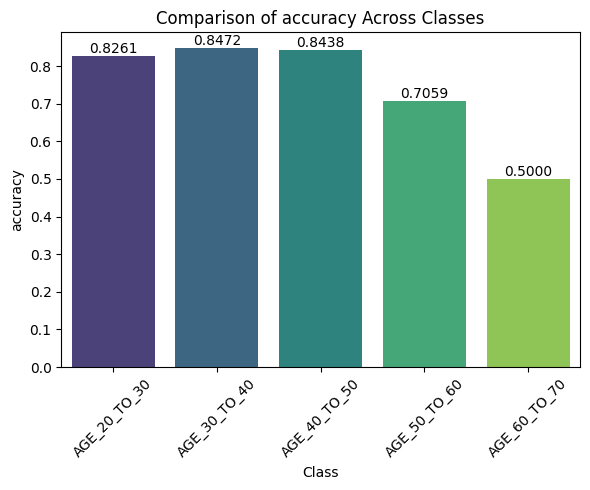




Potential bias detected in log_loss:
Difference: 1.0881

The log loss is lower for AGE_30_TO_40, indicating that the model's probability
estimates are more accurate and well-calibrated for this group. This suggests
that the model is more confident and reliable in its predictions for
AGE_30_TO_40. For AGE_60_TO_70, the higher log loss indicates less accurate
probability estimates, which could lead to less reliable decision-making and
potential unfair treatment.


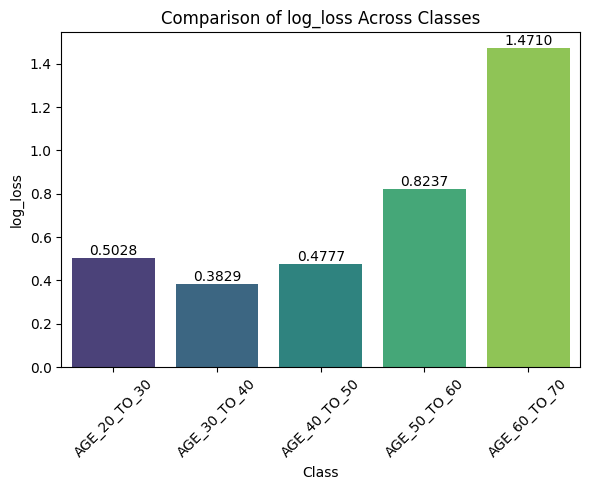




Potential bias detected in proportional_parity:
Difference: 0.4222

The model predicts favorable outcomes more often for AGE_30_TO_40. This
indicates a potential systemic bias in the model's predictions, favoring
AGE_30_TO_40 over other classes, especially AGE_60_TO_70. As a result, other
classes may be disproportionately denied opportunities or benefits, perpetuating
or exacerbating existing inequalities.


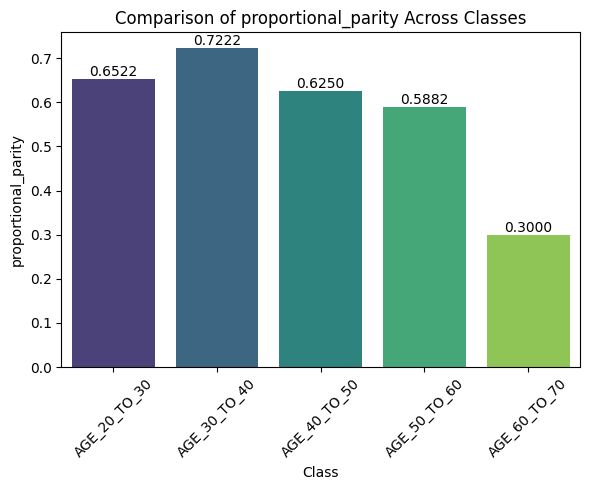




Potential bias detected in equal_parity:
Difference: 49.0000

There is a disparity in equal treatment between classes, with AGE_30_TO_40 being
favored. This suggests that the model is not treating all groups equally, which
could lead to discriminatory outcomes. Other classes, particularly AGE_60_TO_70,
may face systemic disadvantages in various decision-making processes where this
model is applied.


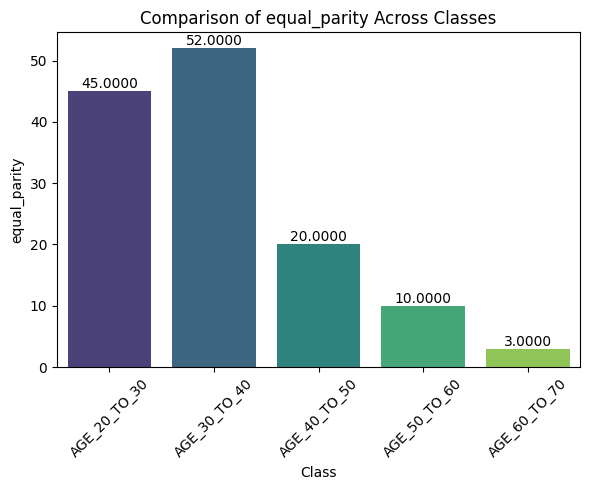




Potential bias detected in true_favourable_rate_parity:
Difference: 0.3667

The true positive rate is higher for AGE_30_TO_40. This means the model is
better at correctly identifying positive instances for AGE_30_TO_40, which could
lead to more opportunities or benefits for this group. In contrast, other
classes, especially AGE_60_TO_70, may experience higher rates of false
negatives, resulting in missed opportunities and underrepresentation in positive
outcomes.


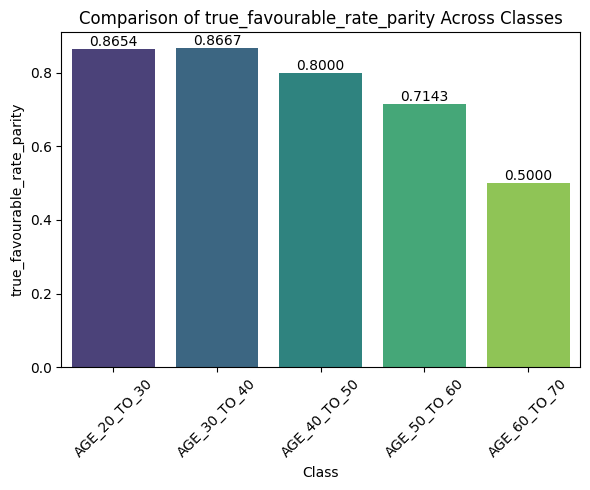




Potential bias detected in true_unfavourable_rate_parity:
Difference: 0.5000

The true negative rate is higher for AGE_40_TO_50. This indicates that the model
is more effective at correctly identifying negative instances for AGE_40_TO_50,
which could lead to fewer false alarms or penalties for this group. Conversely,
other classes, particularly AGE_60_TO_70, may face more false positives,
potentially resulting in unwarranted scrutiny, penalties, or negative outcomes.


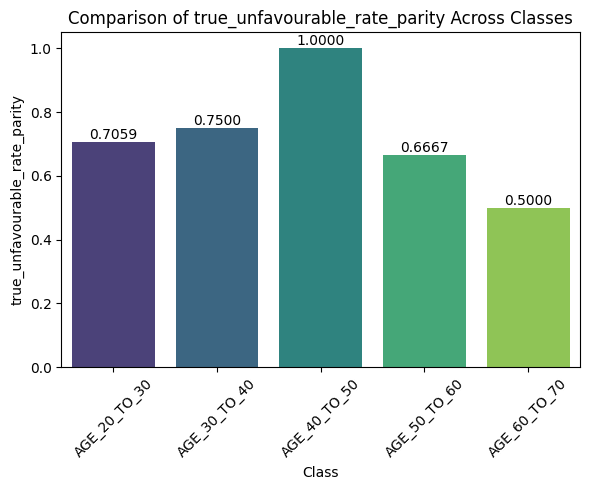




Potential bias detected in favourable_predictive_value:
Difference: 0.4000

Positive predictions are more accurate for AGE_40_TO_50. This suggests that when
the model predicts a positive outcome, it's more likely to be correct for
AGE_40_TO_50, potentially leading to more trust in positive predictions for this
group. For other classes, especially AGE_60_TO_70, positive predictions may be
less reliable, which could result in unwarranted positive outcomes or decreased
trust in the model's positive predictions for these groups.


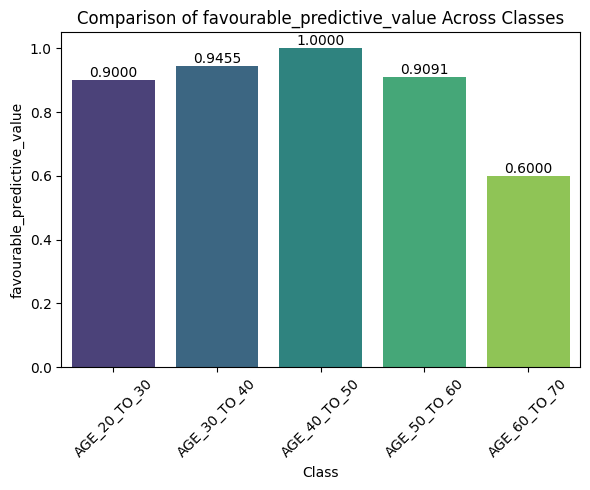




Potential bias detected in unfavourable_predictive_value:
Difference: 0.2982

Negative predictions are more accurate for AGE_20_TO_30. This means that when
the model predicts a negative outcome, it's more likely to be correct for
AGE_20_TO_30. For other classes, particularly AGE_50_TO_60, negative predictions
may be less reliable, potentially leading to unwarranted negative outcomes or
decreased trust in the model's negative predictions for these groups.


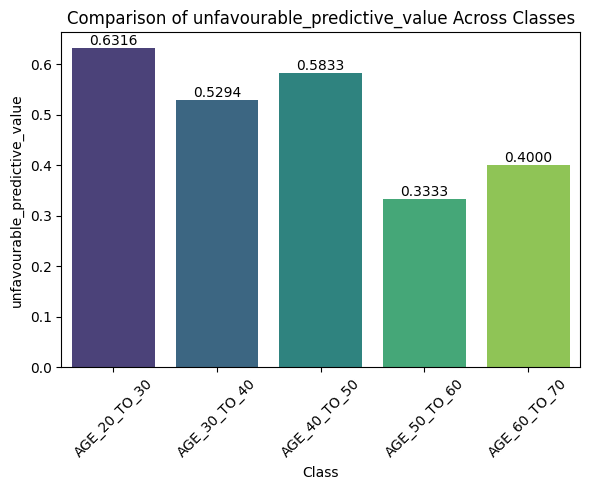




Conclusion:
Potential bias detected in 8 metrics across 5 classes

The model appears to favor AGE_30_TO_40 in 5 out of 8 metrics, indicating
potential bias against AGE_20_TO_30, AGE_40_TO_50, AGE_50_TO_60 and
AGE_60_TO_70. This bias could lead to systemic disadvantages for AGE_20_TO_30,
AGE_40_TO_50, AGE_50_TO_60 and AGE_60_TO_70 across various aspects of the
model's performance. Particular attention should be paid to AGE_50_TO_60 and
AGE_60_TO_70, as they appear to be the most disadvantaged across the metrics.
Further investigation and potential mitigation strategies should be considered
to ensure fair treatment across all groups. This may include adjusting the
model, collecting more representative data, or implementing post-processing
techniques to balance outcomes.


In [14]:
estimate_bias_for_age(10, 0.1)

Potential bias detected in accuracy:
Difference: 0.1081

The model appears to be more accurate for MALES. This suggests that the model's
predictions are more reliable for MALES, which could lead to better outcomes and
decision-making for this group. Conversely, other classes, especially FEMALES,
may face less accurate predictions, potentially resulting in unfair treatment or
missed opportunities.


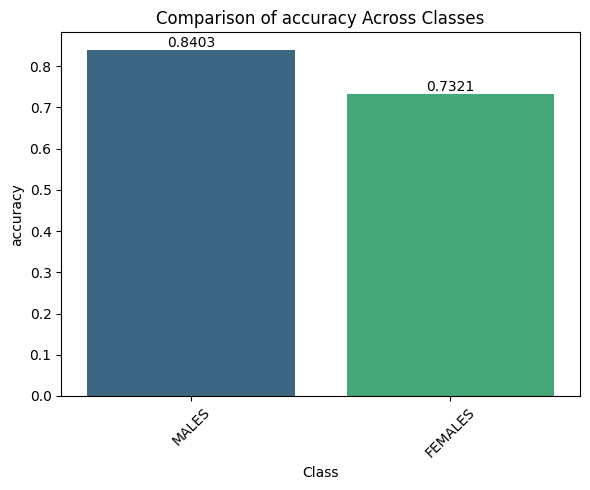




Potential bias detected in log_loss:
Difference: 0.2814

The log loss is lower for MALES, indicating that the model's probability
estimates are more accurate and well-calibrated for this group. This suggests
that the model is more confident and reliable in its predictions for MALES. For
FEMALES, the higher log loss indicates less accurate probability estimates,
which could lead to less reliable decision-making and potential unfair
treatment.


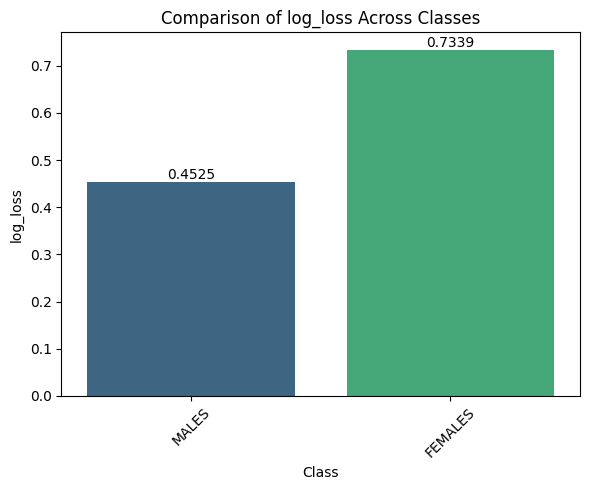




Potential bias detected in equal_parity:
Difference: 62.0000

There is a disparity in equal treatment between classes, with MALES being
favored. This suggests that the model is not treating all groups equally, which
could lead to discriminatory outcomes. Other classes, particularly FEMALES, may
face systemic disadvantages in various decision-making processes where this
model is applied.


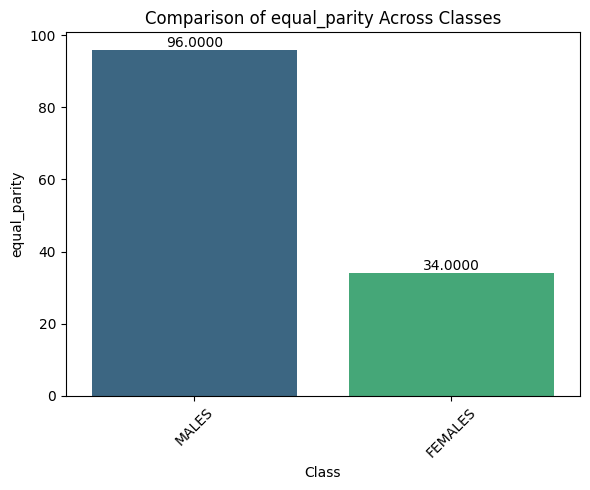




Potential bias detected in true_unfavourable_rate_parity:
Difference: 0.2231

The true negative rate is higher for MALES. This indicates that the model is
more effective at correctly identifying negative instances for MALES, which
could lead to fewer false alarms or penalties for this group. Conversely, other
classes, particularly FEMALES, may face more false positives, potentially
resulting in unwarranted scrutiny, penalties, or negative outcomes.


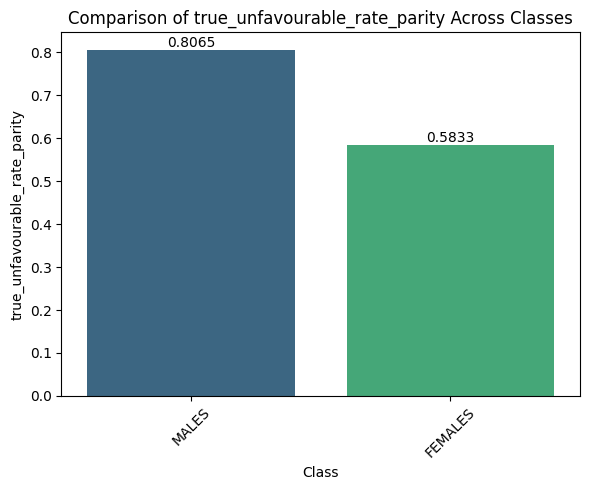




Potential bias detected in unfavourable_predictive_value:
Difference: 0.1835

Negative predictions are more accurate for MALES. This means that when the model
predicts a negative outcome, it's more likely to be correct for MALES. For other
classes, particularly FEMALES, negative predictions may be less reliable,
potentially leading to unwarranted negative outcomes or decreased trust in the
model's negative predictions for these groups.


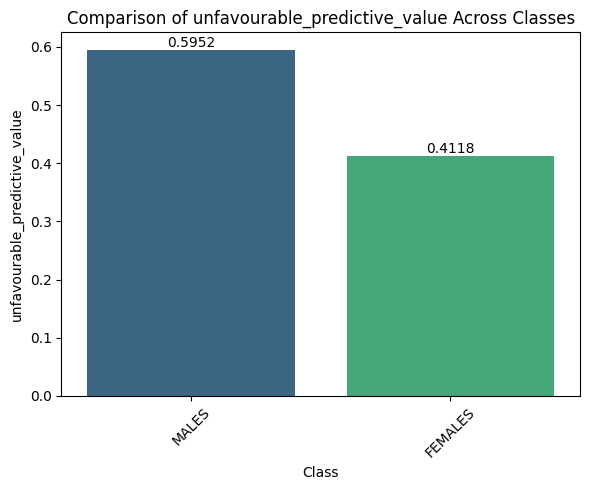




Conclusion:
Potential bias detected in 5 metrics across 2 classes

The model appears to favor MALES in 5 out of 5 metrics, indicating potential
bias against FEMALES. This bias could lead to systemic disadvantages for FEMALES
across various aspects of the model's performance. Particular attention should
be paid to FEMALES, as they appear to be the most disadvantaged across the
metrics. Further investigation and potential mitigation strategies should be
considered to ensure fair treatment across all groups. This may include
adjusting the model, collecting more representative data, or implementing post-
processing techniques to balance outcomes.


In [15]:
estimate_bias_for_gender(0.1)

In [16]:
#estimate_bias_for_gender_and_age(0.1)